In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from bidi.algorithm import get_display
pd.options.display.max_rows = 1000
pd.set_option('display.max_columns', None)
from anlysis_functions.funcs import get_groupby_plot, get_crosstab_table, get_distributions, get_groupby_data, get_barplot

In [2]:
sns.set(rc={"figure.dpi":100, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")
sns.set_palette("pastel")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [5]:
df = pd.read_csv("/Users/shakedcaspi/work/mom/flu_corona/no_wf_data/no_wf_data.csv")
df.drop("Unnamed: 0", inplace=True, axis=1)
df.shape

(2024, 47)

# Preprocessing

### Split between features and target column and removing unnecessary data based on domain knowledge

In [6]:
x_cols = df.columns.tolist()
x_cols.remove("id")
x_cols.remove("flu_vaccine_fall")
x_cols.remove("will_vaccinated_for_corona")

X = df[x_cols].copy()
Y = df.flu_vaccine_fall

In [7]:
X.drop(["is_wf", "sub_sample", "religious_identity_limited", "med_profession", "tumor_disease", "health_job_binary", "had_corona", "kids_groups", "age_cont", "bidud_how_much"], axis=1, inplace=True)

In [8]:
def get_object_cols(df,cols):
    res = []
    for i in cols:
        if df[i].dtype == "object":
            res.append(i)
    return res
obj_cols = get_object_cols(X,X.columns)

### One Hot Encoder For Categorical Features

In [9]:
from sklearn.preprocessing import OneHotEncoder

In [10]:
res = []
for col in obj_cols:
    for name in X[col].unique().tolist():
        res.append(col + "_" + name)
        
onehot = OneHotEncoder(dtype=np.int, sparse=True)
nominals = pd.DataFrame(
    onehot.fit_transform(X[obj_cols]).toarray(),
    columns=res)
X.drop(obj_cols, axis=1, inplace=True)

In [11]:
X = pd.concat([X, nominals], axis=1).copy()

# Modeling 

In [14]:
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

## Tune Hyperparametes for Logistic Regression Model

In [15]:
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [1.0, 0.5, 0.2, 0.1, 0.15]
# max_iter = [10000, 1000]

In [16]:
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='f1')

grid_result = grid_search.fit(X, Y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.883530 using {'C': 0.5, 'penalty': 'l2', 'solver': 'liblinear'}
0.882674 (0.022962) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.882674 (0.022962) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.883161 (0.023038) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.882623 (0.022823) with: {'C': 0.5, 'penalty': 'l2', 'solver': 'newton-cg'}
0.882623 (0.022823) with: {'C': 0.5, 'penalty': 'l2', 'solver': 'lbfgs'}
0.883530 (0.022800) with: {'C': 0.5, 'penalty': 'l2', 'solver': 'liblinear'}
0.882728 (0.023336) with: {'C': 0.2, 'penalty': 'l2', 'solver': 'newton-cg'}
0.882728 (0.023336) with: {'C': 0.2, 'penalty': 'l2', 'solver': 'lbfgs'}
0.882662 (0.023830) with: {'C': 0.2, 'penalty': 'l2', 'solver': 'liblinear'}
0.881189 (0.023351) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.881189 (0.023351) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.882348 (0.025029) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.882345 (0.023584) 

# Model

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [18]:
print("TRAIN DATA")
print("flu_vaccine_fall = 0 is", str(round(y_train[y_train == 0].shape[0]/y_train.shape[0]*100))+"%")
print("flu_vaccine_fall = 1 is ", str(round(y_train[y_train == 1].shape[0]/y_train.shape[0]*100))+"%")
print("-----------------------------")
print("TEST DATA")
print("flu_vaccine_fall = 0 is", str(round(y_test[y_test == 0].shape[0]/y_test.shape[0]*100))+"%")
print("flu_vaccine_fall = 1 is ", str(round(y_test[y_test == 1].shape[0]/y_test.shape[0]*100))+"%")
print("-----------------------------")
print("Train Size -",y_train.shape[0])
print("Test Size -",y_test.shape[0])

TRAIN DATA
flu_vaccine_fall = 0 is 49%
flu_vaccine_fall = 1 is  51%
-----------------------------
TEST DATA
flu_vaccine_fall = 0 is 46%
flu_vaccine_fall = 1 is  54%
-----------------------------
Train Size - 1518
Test Size - 506


____

In [19]:
lr = LogisticRegression(solver='newton-cg', C=0.5, 
                        fit_intercept=True, max_iter=1000, 
                        penalty="l2", random_state=42, n_jobs=-1)

In [20]:
lr.fit(X_train, y_train)

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=-1, penalty='l2', random_state=42,
                   solver='newton-cg', tol=0.0001, verbose=0, warm_start=False)

In [21]:
lr_predict = lr.predict(X_test)

In [22]:
lr.score(X_train, y_train)

0.8992094861660079

In [23]:
lr.score(X_test, y_test)

0.8636363636363636

# Evaluation

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
confusion = confusion_matrix(y_test, lr_predict)
confusion
# array([[1247,  785],      
#       [ 143,  220]])

array([[203,  32],
       [ 37, 234]])

In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_test, lr_predict, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.85      0.86      0.85       235
           1       0.88      0.86      0.87       271

    accuracy                           0.86       506
   macro avg       0.86      0.86      0.86       506
weighted avg       0.86      0.86      0.86       506



# Explanation of variance

In [26]:
errors = y_test - lr_predict
sse = sum(errors**2)
ssr = sum((y_test - np.mean(y_test, axis=0))**2)
sst = sse + ssr
# Sxx = sum((X_test-np.mean(X_test))**2)
# Syy = sum((y_test-np.mean(y_test))**2)
# Sxy = sum((X_test-np.mean(X_test))*(y_test-np.mean(y_test)))

In [27]:
print("sse", sse)
print("ssr", ssr)
print("sst", sst)

sse 69.0
ssr 125.85968379446604
sst 194.85968379446604


In [28]:
R_squared = ssr/sst
print(round(R_squared*100,2),"%")

64.59 %


# AUC Curve

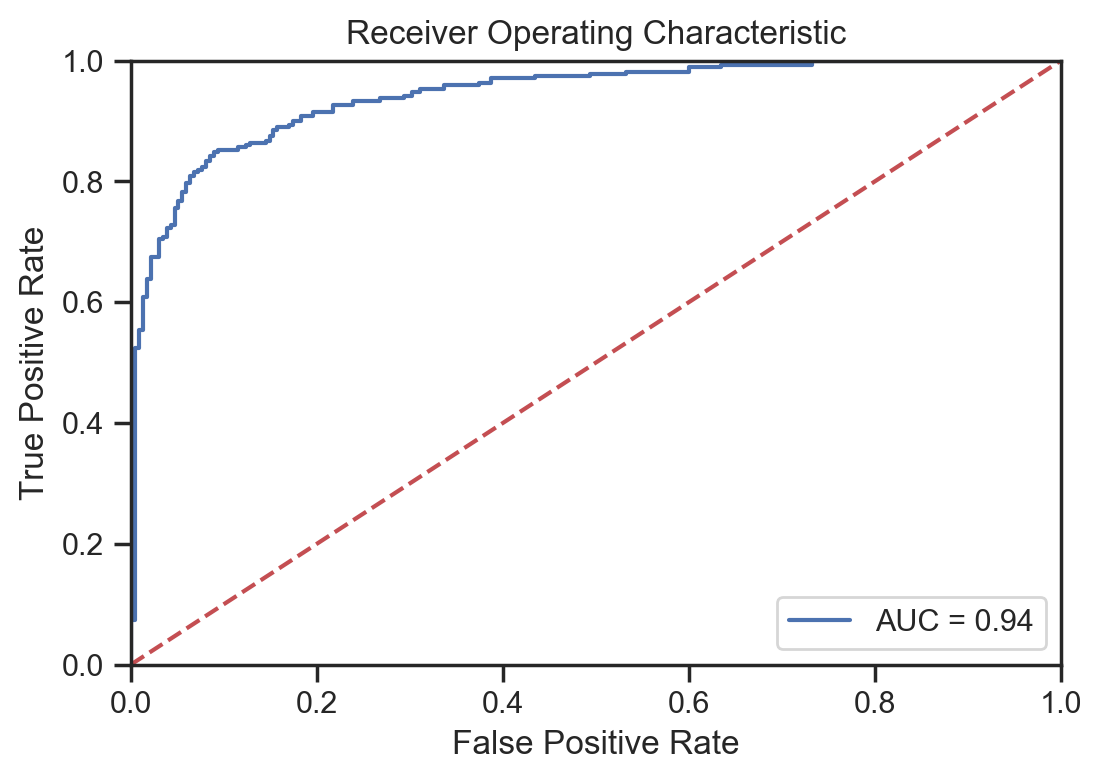

In [30]:
import sklearn.metrics as metrics
probs = lr.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Model Coefficients and Features Importance

In [31]:
weights = lr.coef_

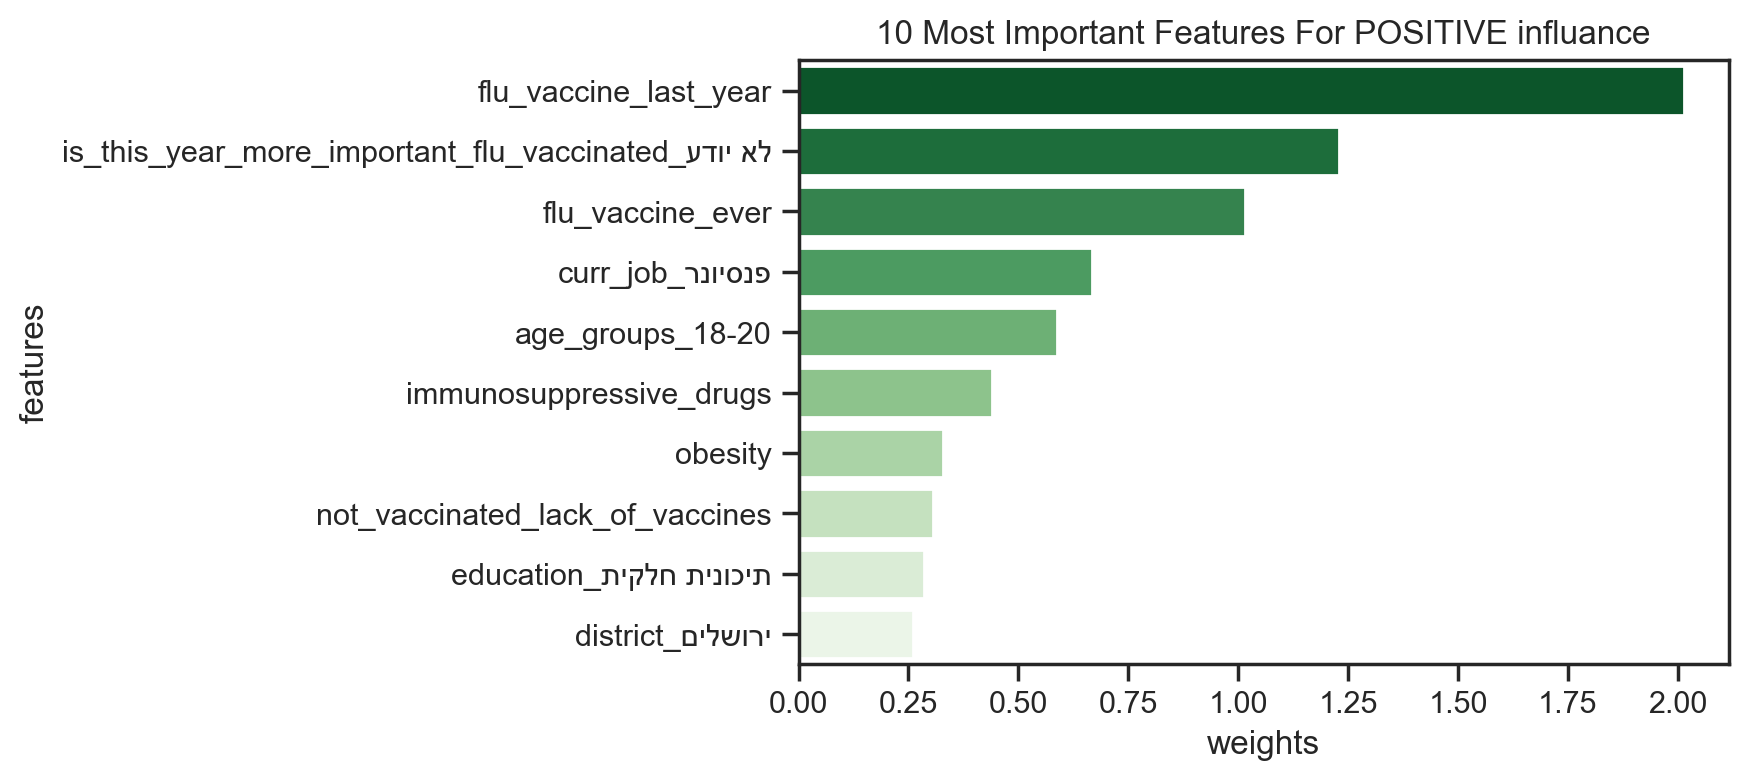

In [32]:
features_importance = pd.DataFrame(data={"features": X.columns, "weights": weights[0]})
features_importance.sort_values("weights", ascending=False, inplace=True)

ylabels = []
ax = sns.barplot(y = "features", x = "weights", data=features_importance[:10], palette="Greens_r")
for i, p in enumerate(ax.patches):
    ylabels.append(get_display(str(features_importance[:10]["features"].iloc[i])))
ax.set_yticklabels(ylabels, ha="right")
plt.title("10 Most Important Features For POSITIVE influance")
sns.set(font_scale=1)
plt.show()

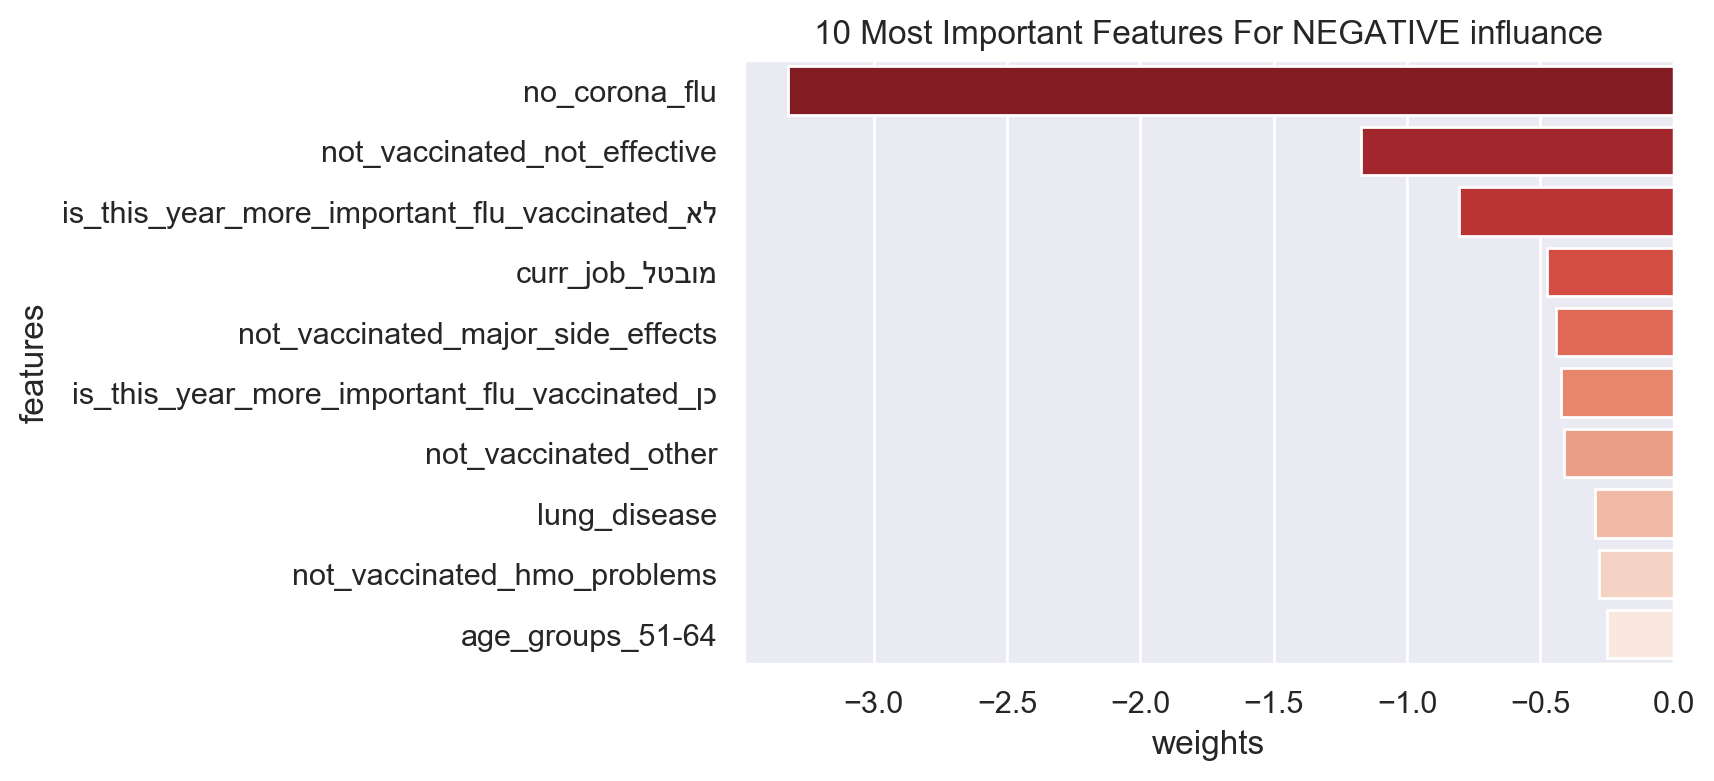

In [33]:
features_importance.sort_values("weights", ascending=True, inplace=True)

ylabels = []
ax = sns.barplot(y = "features", x = "weights", data=features_importance[:10], palette="Reds_r")
for i, p in enumerate(ax.patches):
    ylabels.append(get_display(str(features_importance[:10]["features"].iloc[i])))
ax.set_yticklabels(ylabels, ha="right")
plt.title("10 Most Important Features For NEGATIVE influance")
sns.set(font_scale=1)
plt.show()

In [34]:
features_importance.sort_values("weights").head()

,features,weights
26,no_corona_flu,-3.322189
9,not_vaccinated_not_effective,-1.172088
33,is_this_year_more_important_flu_vaccinated_לא,-0.806396
30,curr_job_מובטל,-0.476212
10,not_vaccinated_major_side_effects,-0.439580


It's interesting to see that according to the coefficients the strongest features are: <br/>
<ul> <em><u>Positive effect on people for influenza vaccination: </u></em>
        <li>flu_vaccine_last_year</li>
        <li>is_this_year_more_important_flu_vaccinated_לא_יודע</li>
        <li>flu_vaccine_ever</li>
</ul>
<ul> <em><u> Negative effect on people for influenza vaccination: </u></em>
        <li>no_corona_flu</li>
        <li>not_vaccinated_not_effective</li>
        <li>is_this_year_more_important_flu_vaccinated_לא</li>
        <li>curr_job_מובטל</li>
</ul>
It's interesting to see that unemployed was a strong negative feature for flu vaccination. <br><br/>
<b><u>If we looking on the 5 top important features based on REF - </u></b>
<ul> 
        <li>age_groups_18-20</li>
        <li>is_this_year_more_important_flu_vaccinated_לא יודע</li>
        <li>not_vaccinated_lack_of_vaccines</li>
        <li>flu_vaccine_ever</li>
        <li>flu_vaccine_last_year</li>
</ul>

# Features Importance with Recursive Feature Elimination

In [35]:
from sklearn.feature_selection import RFE

In [36]:
rfe = RFE(lr, 5)
fit = rfe.fit(X, Y)

In [37]:
rfe_results = pd.DataFrame(data={"features":X.columns, "ranks":fit.ranking_, "selected_features": fit.support_}).sort_values("ranks")

<p style="font-size:18px;"> note the rank = 1 is the highest rank </p>

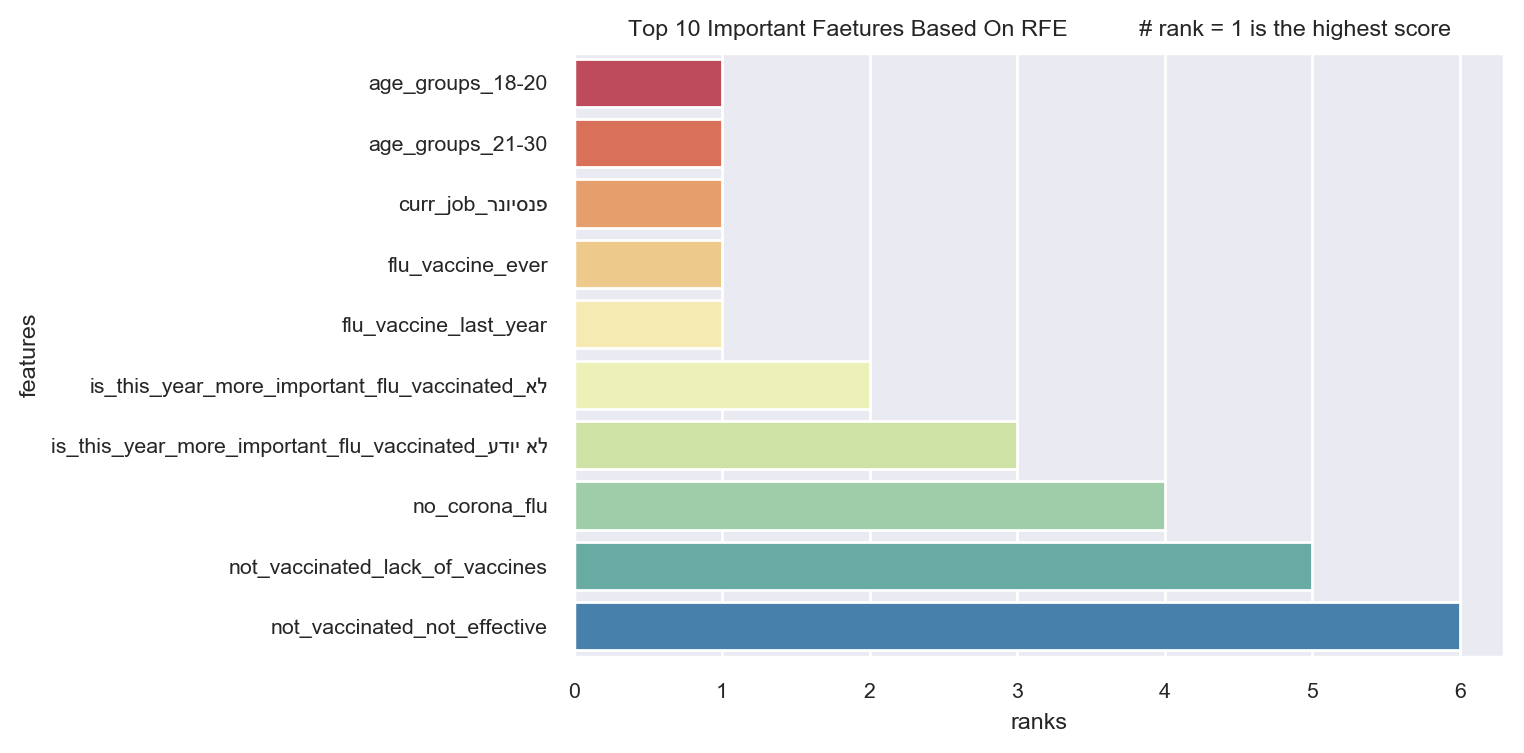

In [38]:
get_barplot(y = "features", x = "ranks", df=rfe_results[:10], figsize=(6,4), colors="Spectral")
plt.title("Top 10 Important Faetures Based On RFE           # rank = 1 is the highest score");

# Features Importance with Principal Component Analysis

## Will be added in the futures